In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon
import rtree as rt

In [6]:
def generate_data(**kwargs):
    lower_limit = kwargs.get('lower_limit', 0) 
    upper_limit = kwargs.get('upper_limit', 100) 
    n_samples = kwargs.get('n_samples', 100)
    resolution = kwargs.get('resolution', None) 
    
    if resolution:
        width = resolution
        height = resolution
    else:
        width = kwargs.get('width', 10)
        height = kwargs.get('height', 10)
    
    grid = gpd.GeoDataFrame()
    for row in range(lower_limit+height, upper_limit+height, height):
        for col in range(lower_limit+width, upper_limit+width, width):
            poly = Polygon(((col-width, row), (col, row), (col, row-height), 
                           (col-width, row-height),(col-width, row)))
            temp = gpd.GeoDataFrame({'geometry': [poly]})
            grid = grid.append(temp)
    grid.reset_index(drop=True, inplace=True)
    
    x = np.random.uniform(lower_limit, upper_limit, n_samples)
    y = np.random.uniform(lower_limit, upper_limit, n_samples)
    points = gpd.GeoDataFrame(data={'x':x, 'y':y})
    points['geometry'] = points.apply(lambda row: Point((row['x'], row['y'])), axis=1)
    
    return grid, points

def compute_hits(grid, points):
    rtree = rt.index.Index()
    grid_hits = np.zeros(grid.size)
    
    for i, point in points['geometry'].iteritems():
        rtree.insert(i, point.bounds)
    
    df_ref = gpd.GeoDataFrame()
    for i, row in grid.iterrows():
        poly = row['geometry']
        sindex_matches = list(rtree.intersection(poly.bounds))
        points_matches = points.iloc[sindex_matches]
        points_matches = points_matches[points_matches.intersects(poly)]
        points_matches['grid'] = i
        df_ref = df_ref.append(points_matches)
    return df_ref
    
    

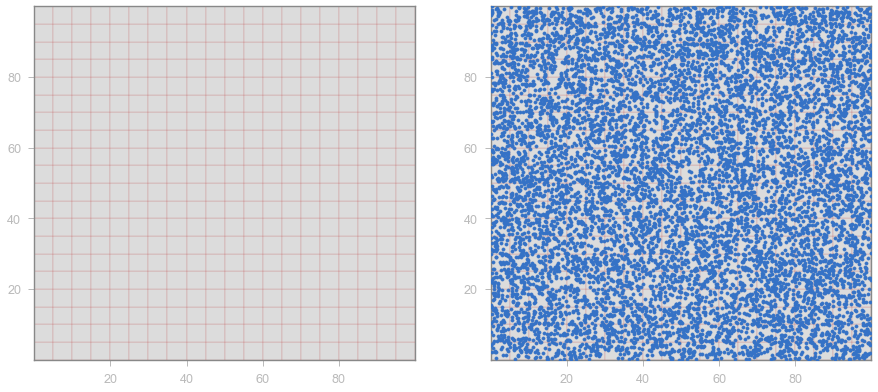

In [4]:
grid, points = generate_data(resolution=5, n_samples=10000)
west, south, east, north = points.unary_union.bounds

fig, ax = plt.subplots(1, 2, figsize=(15, 6.5))

for i, g in grid['geometry'].iteritems():
    patch = PolygonPatch(g, fc='#dcdcdc', ec='r', zorder=2)
    patch2 = PolygonPatch(g, fc='#dcdcdc', ec='r', zorder=2)
    ax[0].add_patch(patch)
    ax[1].add_patch(patch2)

ax[0].set_xlim(west, east)
ax[0].set_ylim(south, north)
ax[1].set_xlim(west, east)
ax[1].set_ylim(south, north)

ax[1].scatter(points.iloc[:, 0].values, points.iloc[:, 1].values, 
              zorder=3, marker='.', color='b')
plt.show()

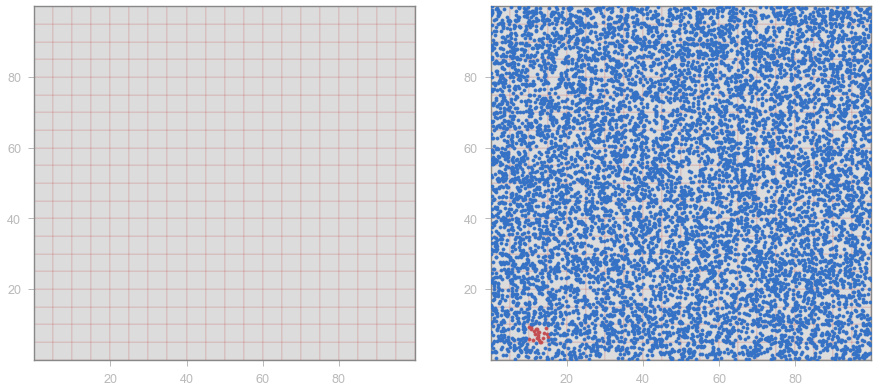

In [7]:
df_ref = compute_hits(grid, points)
within = df_ref.query('grid == 22')
outside = df_ref[~df_ref.isin(within)]


fig, ax = plt.subplots(1, 2, figsize=(15, 6.5))

for i, g in grid['geometry'].iteritems():
    patch = PolygonPatch(g, fc='#dcdcdc', ec='r', zorder=2)
    patch2 = PolygonPatch(g, fc='#dcdcdc', ec='r', zorder=2)
    ax[0].add_patch(patch)
    ax[1].add_patch(patch2)

ax[0].set_xlim(west, east)
ax[0].set_ylim(south, north)
ax[1].set_xlim(west, east)
ax[1].set_ylim(south, north)

# ax[0].scatter(points.iloc[:, 0].values, points.iloc[:, 1].values, 
#               zorder=3, marker='.', color='b')

ax[1].scatter(within['x'].values, within['y'].values, zorder=3, marker='.', color='r')
ax[1].scatter(outside['x'].values, outside['y'].values, zorder=3, marker='.', color='b')

plt.show()